In [ ]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

drive.mount('/content/drive')
plt.style.use('dark_background')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_path = r'/content/drive/Othercomputers/My Laptop/Software_Engineering/Artificial_Intelligence/Cellula_Internship/Computer_Vision/Datasets/Water_Segmentation/images/'
labels_path = r'/content/drive/Othercomputers/My Laptop/Software_Engineering/Artificial_Intelligence/Cellula_Internship/Computer_Vision/Datasets/Water_Segmentation/labels/'

In [ ]:
all_labels = os.listdir(labels_path)
all_images = os.listdir(images_path)

In [ ]:
def normalize_channel(channel):
  min_val = np.min(channel)
  max_val = np.max(channel)
  return (channel - min_val) / (max_val - min_val)


def normalize_image(image):
    norm_img = np.zeros_like(image, dtype=np.float32)

    for b in range(image.shape[2]):
        band = image[:, :, b]
        min_val = np.min(band)
        max_val = np.max(band)

        if max_val != min_val:
            norm_img[:, :, b] = (band - min_val) / (max_val - min_val)
        else:
            norm_img[:, :, b] = 0  # or any constant value

    return norm_img

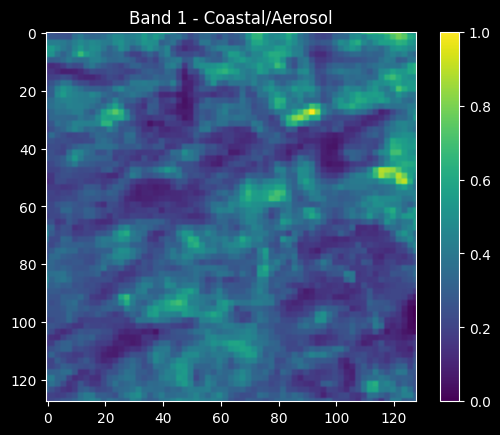

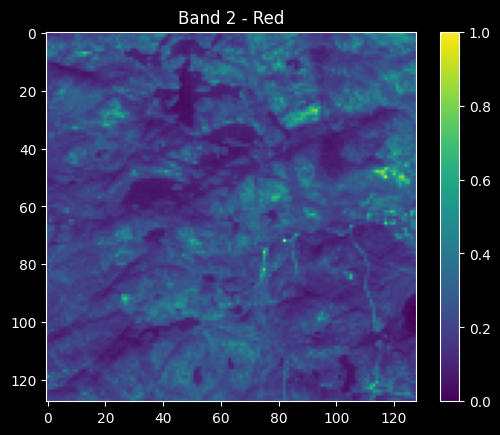

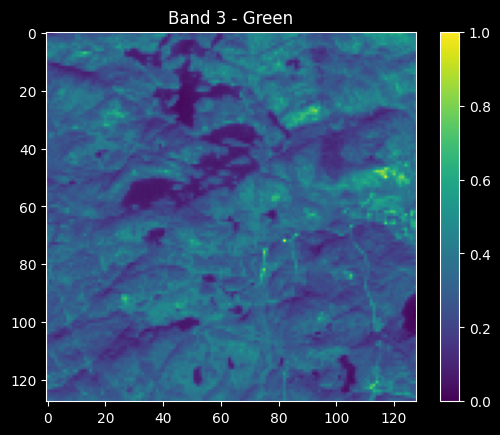

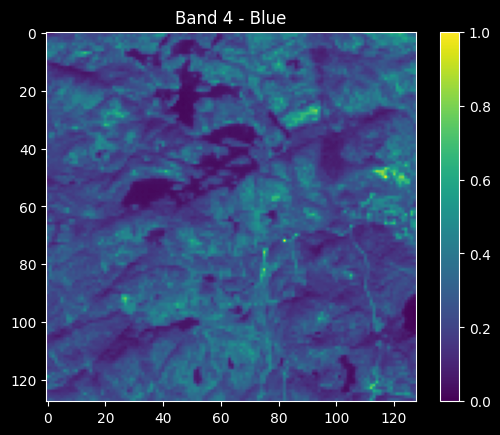

In [ ]:
image_path = os.path.join(images_path, '0.tif')
image = tiff.imread(image_path)

# Display specific bands
bands_to_display = {
    1: 'Coastal/Aerosol',
    2: 'Red',
    3: 'Green',
    4: 'Blue'
}

for band_index, band_name in bands_to_display.items():
    plt.figure()
    band = normalize_channel(image[:, :, band_index - 1])
    plt.imshow(band, cmap='viridis')  # Use a color map like 'viridis'
    plt.title(f'Band {band_index} - {band_name}')
    plt.colorbar()
    plt.show()

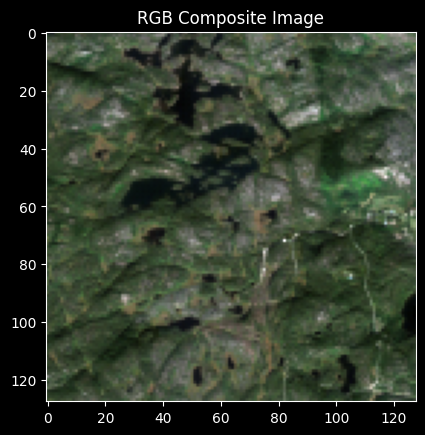

In [ ]:
# Extract bands for RGB composite
blue_band = normalize_channel(image[:, :, 1])
green_band = normalize_channel(image[:, :, 2])
red_band = normalize_channel(image[:, :, 3])

# Stack bands to form an RGB image
rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)

plt.figure()
plt.imshow(rgb_image)
plt.title('RGB Composite Image')
plt.show()

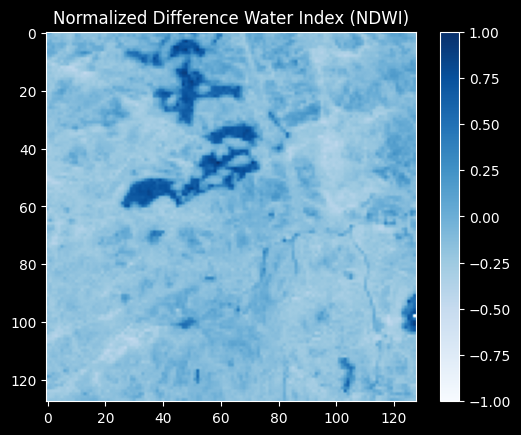

In [ ]:
# Calculate Normalized Difference Water Index ( NDWI )
# NDWI = ( Green - NIR ) / ( Green + NIR )
# NIR means near-infrared

green_band = normalize_channel(image[:, :, 2])
nir_band = normalize_channel(image[:, :, 4])

ndwi = (green_band - nir_band) / (green_band + nir_band)

plt.figure()
plt.imshow(ndwi, cmap='Blues')
plt.title('Normalized Difference Water Index (NDWI)')
plt.colorbar()
plt.show()

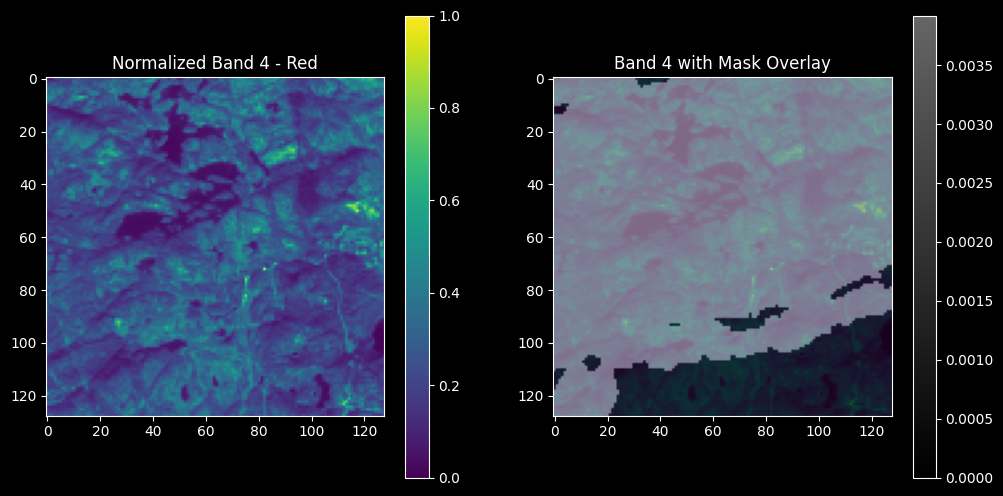

In [ ]:
# Load the mask
mask_path = os.path.join(labels_path, '60.png')  # Adjust if needed
mask = plt.imread(mask_path)

# Display a specific band with mask overlay
plt.figure(figsize=(12, 6))

# Display normalized band
plt.subplot(1, 2, 1)
plt.imshow(normalize_channel(image[:, :, 3]), cmap='viridis')  # Example with Band 4 - Red
plt.title('Normalized Band 4 - Red')
plt.colorbar()

# Overlay mask on the band
plt.subplot(1, 2, 2)
plt.imshow(normalize_channel(image[:, :, 3]), cmap='viridis', alpha=0.6)
plt.imshow(mask, cmap='gray', alpha=0.4)  # Adjust alpha for transparency
plt.title('Band 4 with Mask Overlay')
plt.colorbar()

plt.show()

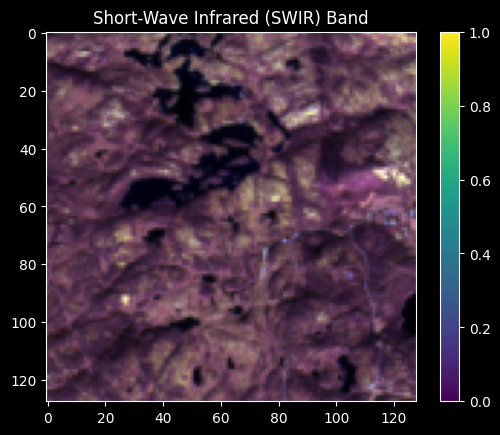

In [ ]:
# Short-Wave Infrared
swir1_band = normalize_channel(image[:, :, 5])
swir2_band = normalize_channel(image[:, :, 6])

composite_image = np.stack((swir1_band, swir2_band, green_band), axis=-1)

plt.figure()
plt.imshow(composite_image)
plt.title('Short-Wave Infrared (SWIR) Band')
plt.colorbar()
plt.show()

In [ ]:
all_files = [i for i in os.listdir(images_path) if i.endswith('.tif')]
random_files = random.sample(all_files, 20)

In [ ]:
fig, axes = plt.subplots(20, 2, figsize=(15, 50))
for i, img in enumerate(random_files):
    image_path = os.path.join(images_path, img)
    image = tiff.imread(image_path)

    blue_band = normalize_channel(image[:, :, 1])
    green_band = normalize_channel(image[:, :, 2])
    red_band = normalize_channel(image[:, :, 3])
    rgb_composite = np.dstack((red_band, green_band, blue_band))

    nir_band = normalize_channel(image[:, :, 4])
    ndwi = (green_band - nir_band) / (green_band + nir_band)

    axes[i, 0].imshow(rgb_composite)
    axes[i, 0].set_title(f'RGB Composite for {img}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(ndwi, cmap='Blues')  # Blue colormap to highlight water
    axes[i, 1].set_title(f'NDWI - Water Detection for {img}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def enhance_mask(mask):
    # Convert the mask to a NumPy array
    mask_array = np.array(mask)

    # Multiply by a constant to enhance contrast
    enhanced_mask = mask_array * 255  # Assuming mask values are in [0, 1]
    enhanced_mask = np.clip(enhanced_mask, 0, 255)  # Ensure the values are within [0, 255]
    return enhanced_mask.astype(np.uint8) # return the image in unsigned int with 8 bits


fig, axes = plt.subplots(20, 3, figsize=(15, 50))
for i, img in enumerate(random_files):
    image_path = os.path.join(images_path, img)
    label_file = os.path.splitext(img)[0] + ".png"  # Assuming mask has the same name with .png extension
    label_path = os.path.join(labels_path, label_file)

    # Load image and mask
    image = tiff.imread(image_path)
    mask = Image.open(label_path)

    # Enhance the mask
    enhanced_mask = enhance_mask(mask)

    # Extract RGB (Blue = Band 2, Green = Band 3, Red = Band 4)
    blue_band = normalize_channel(image[:, :, 1])  # Band 2 - Blue
    green_band = normalize_channel(image[:, :, 2])  # Band 3 - Green
    red_band = normalize_channel(image[:, :, 3])  # Band 4 - Red

    # Create an RGB composite
    rgb_composite = np.dstack((red_band, green_band, blue_band))

    # Extract the NIR band and calculate NDWI
    nir_band = normalize_channel(image[:, :, 4])  # Band 5 - NIR
    ndwi = (green_band - nir_band) / (green_band + nir_band)

    # Display the RGB composite
    axes[i, 0].imshow(rgb_composite)
    axes[i, 0].set_title(f'RGB Composite for {img}')
    axes[i, 0].axis('off')

    # Display the NDWI
    axes[i, 1].imshow(ndwi, cmap='Blues')  # Blue colormap to highlight water
    axes[i, 1].set_title(f'NDWI - Water Detection for {img}')
    axes[i, 1].axis('off')

    # Display the enhanced mask
    axes[i, 2].imshow(enhanced_mask, cmap='gray')  # Grayscale colormap for masks
    axes[i, 2].set_title(f'Enhanced Mask for {img}')
    axes[i, 2].axis('off')

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = []
masks = []

for img in all_images:

    image_path = os.path.join(images_path, img)
    lbl = os.path.splitext(img)[0] + ".png"
    label_path = os.path.join(labels_path, lbl)

    image = tiff.imread(image_path)
    mask = Image.open(label_path)

    # Convert the mask to a NumPy array
    mask = np.array(mask)

    # Binarizes the mask
    # Any non-zero value in the mask becomes 1
    # zero values remain 0
    mask = (mask > 0).astype(np.uint8)

    images.append(image)
    masks.append(mask)

# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Check the shapes of the loaded images and masks
print(f'Loaded {len(images)} images with shape {images.shape}')
print(f'Loaded {len(masks)} masks with shape {masks.shape}')

Loaded 306 images with shape (306, 128, 128, 12)
Loaded 306 masks with shape (306, 128, 128)


In [ ]:
def len_and_percentage(split_data, data_name):
    print(f"{data_name}: {len(split_data)}, percentage: {round(len(split_data) / len(images_normalized) * 100)}%")

In [ ]:
images_normalized = np.array([normalize_image(img) for img in images])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    images_normalized,
    masks,
    test_size=0.2,
    random_state=42
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.3,
    random_state=42
    )

len_and_percentage(X_train, 'X_train')
len_and_percentage(y_train, 'y_train')

len_and_percentage(X_val, 'X_val')
len_and_percentage(y_val, 'y_val')

len_and_percentage(X_test, 'X_test')
len_and_percentage(y_test, 'y_test')

X_train: 170, percentage: 56%
y_train: 170, percentage: 56%
X_val: 74, percentage: 24%
y_val: 74, percentage: 24%
X_test: 62, percentage: 20%
y_test: 62, percentage: 20%


In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    brightness_range=[0.8, 1.2] # 1.0 means no change, values below 1.0 darken the image, and values above 1.0 brighten it.
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32,
    shuffle=True
    )

val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=32,
    shuffle=False
    )

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (170, 128, 128, 12) (12 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (74, 128, 128, 12) (12 channels).
  warnings.warn(


In [ ]:
print("Shape of X_train[0]:", X_train[0].shape)
print("Shape of y_train[0]:", y_train[0].shape)

print("Shape of X_val[0]:", X_val[0].shape)
print("Shape of y_val[0]:", y_val[0].shape)

print("Shape of X_test[0]:", X_test[0].shape)
print("Shape of y_test[0]:", y_test[0].shape)

Shape of X_train[0]: (128, 128, 12)
Shape of y_train[0]: (128, 128)
Shape of X_val[0]: (128, 128, 12)
Shape of y_val[0]: (128, 128)
Shape of X_test[0]: (128, 128, 12)
Shape of y_test[0]: (128, 128)


In [ ]:
def unet_model(input_shape, l2_lambda=0.01, spatial_dropout_rate=0.3):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv4)
    drop4 = SpatialDropout2D(spatial_dropout_rate)(conv4)  # Spatial Dropout in Encoder
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv5)
    drop5 = SpatialDropout2D(spatial_dropout_rate)(conv5)  # Spatial Dropout in Bottleneck

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv9)

    # Output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example usage
input_shape = (128, 128, 12)
model = unet_model(input_shape, l2_lambda=0.001, spatial_dropout_rate=0.2)  # Adjust Spatial Dropout rate as needed
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 12)]       0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 128, 128, 64)         6976      ['input_5[0][0]']             
                                                                                                  
 conv2d_32 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_31[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_32[0][0]']           
 g2D)                                                                                       

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [47]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100
6/6 [==============================] - 32s 5s/step - loss: 5.0487 - accuracy: 0.7363 - val_loss: 3.2416 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 28s 5s/step - loss: 2.6004 - accuracy: 0.8588 - val_loss: 1.6977 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 28s 5s/step - loss: 1.4129 - accuracy: 0.8820 - val_loss: 1.0389 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 28s 5s/step - loss: 0.9518 - accuracy: 0.8829 - val_loss: 0.8112 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 28s 5s/step - loss: 0.7701 - accuracy: 0.8940 - val_loss: 0.6888 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 27s 4s/step - loss: 0.6567 - accuracy: 0.8966 - val_loss: 0.5891 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 28s 5s/step - loss: 0.5768 - accuracy

In [48]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2/2 [==============================] - 1s 665ms/step - loss: 0.2683 - accuracy: 0.9200
Test Loss: 0.2683
Test Accuracy: 0.9200


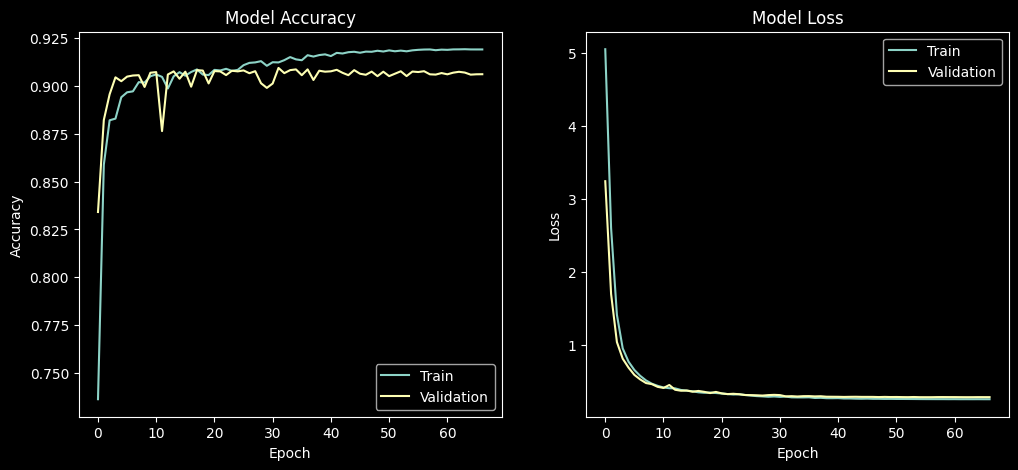

In [49]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

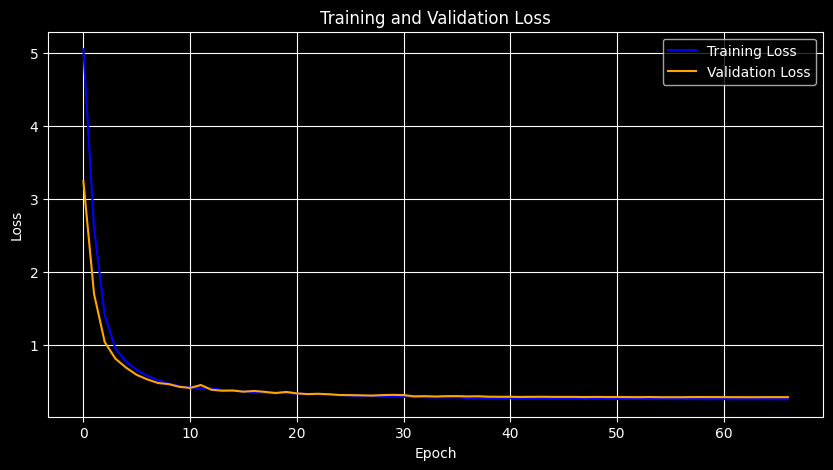

In [50]:
def plot_training_history(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')  # Might be None if validation data was not provided

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')

    if val_loss is not None:
        plt.plot(val_loss, label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'history' is the result from model.fit()
plot_training_history(history)

In [51]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# If the model outputs probabilities, convert them to class labels
y_pred_binary = (y_pred > 0.5).astype(np.uint8)  # For multi-class, use argmax; for binary, use a threshold

# Flatten arrays for evaluation
y_test_flat = y_test.flatten()
y_pred_labels_flat = y_pred_binary.flatten()

# Calculate metrics
f1 = f1_score(y_test_flat, y_pred_labels_flat, average='weighted')
precision = precision_score(y_test_flat, y_pred_labels_flat, average='weighted')
recall = recall_score(y_test_flat, y_pred_labels_flat, average='weighted')
accuracy = accuracy_score(y_test_flat, y_pred_labels_flat)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

2/2 [==============================] - 2s 635ms/step
F1 Score: 0.9179972845808833
Precision: 0.9194268089649257
Recall: 0.9200331164944556
Accuracy: 0.9200331164944556


In [55]:
def visualize_prediction(X_test, y_test, y_pred, index):
    # Select the test image, ground truth mask, and predicted mask at the given index
    image = X_test[index]
    true_mask = y_test[index].squeeze()  # Remove the channel dimension
    pred_mask = y_pred[index].squeeze()  # Remove the channel dimension

    # Plot the images
    plt.figure(figsize=(12, 6))

    # Display the test image (visualize only RGB channels if available)
    if image.shape[-1] >= 3:
        image_rgb = image[:, :, :3]
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title("Test Image (RGB)")
    else:
        plt.subplot(1, 3, 1)
        plt.imshow(image[:, :, 0], cmap='gray')
        plt.title("Test Image (Grayscale)")

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Use the trained model to make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Binarize the predicted masks

# Randomly select 20 indices
num_samples = 20
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Visualize 20 random predictions
for idx in random_indices:
    visualize_prediction(X_test, y_test, y_pred, index=idx)


Output hidden; open in https://colab.research.google.com to view.